In [31]:
import torch
from torch import nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

# 1. Get the Data
This is going to be using the Food101 dataset (https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). It containts 1000 of 101 different kinds of food (totally aroud 100,000 images).
\
\
For now we are going to stick with three different kinds of food for our CNN classification model. 
\
\
The data has been pre-formatted, however there is code that contains the formatting. 

In [32]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("more_data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

more_data/pizza_steak_sushi directory exists.


In [33]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('more_data/pizza_steak_sushi/train'),
 PosixPath('more_data/pizza_steak_sushi/test'))

# 2. Visualize an image
We are now going to quickly just visualize the data so that we can see what we're working with. 

Random image path: more_data/pizza_steak_sushi/train/pizza/3391208.jpg
Image class: pizza
Image height: 512
Image width: 341


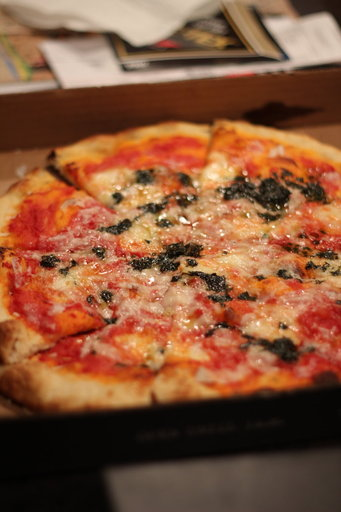

In [34]:
import random
from PIL import Image

# Set seed
random.seed(40) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(340.5), np.float64(511.5), np.float64(-0.5))

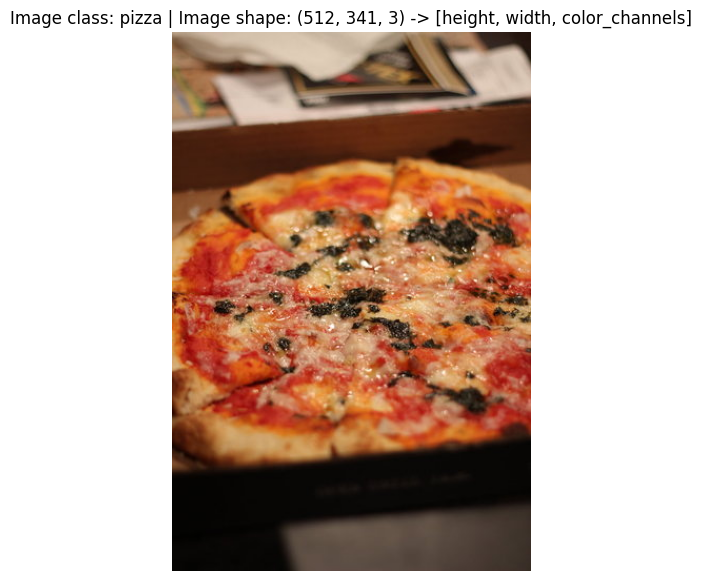

In [35]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.array(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# 3. Transforming data
We obviously first need to transform our data into tensors so that we can use them in pytorch. We also want to turn it into a pytorch Dataset so that we can more easily interact with it. 
\
\
Since we're working with a vision problem, we'll use torchvision.datasets for our data loading functions and torchvision.transforms for preparing the data.

In [36]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

The torchvision.transforms model contains pre-built methods for formatting images, turning them into tensors and manipulating them. We are going to:
1. Resize the images using transforms.Resize()
2. Flip the images randomly 
3. Turn the images from PIL image to a pytorch tensor

In [37]:
data_transform = transforms.Compose([
    #Resize the images to 64x64
    transforms.Resize(size=(64, 64)),

    # Flip the images horizontally randomly
    # Where p is the probability of the flip
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor()
])

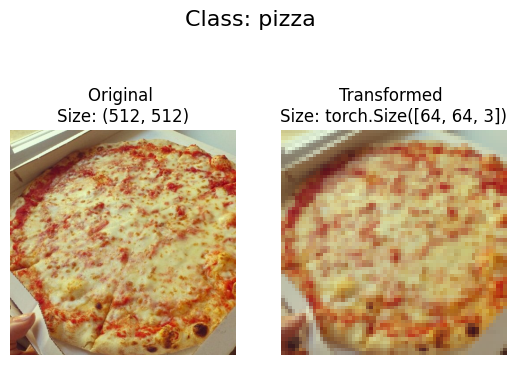

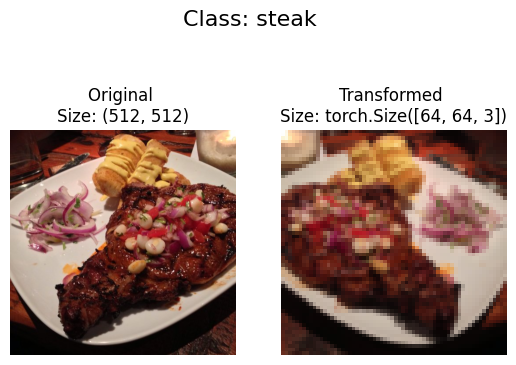

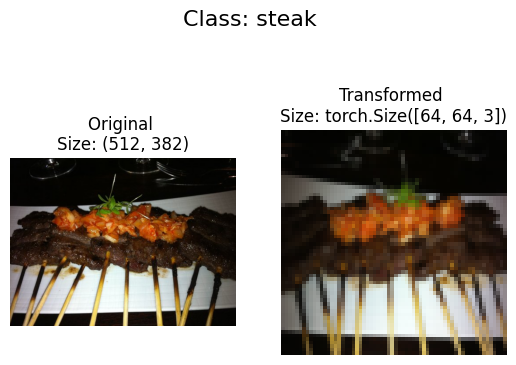

In [38]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

# 4. Loading Image Data Using ImageFolder
This is where we can turn our image data into an actual pytorch dataset. The ImageFolder function is used when we have a directory that is in the classic image classification format. So we pass the path to that folder and a series of transforms we want to perform on the images to the function.

In [39]:
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None # these are transforms to perform on the labels
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: more_data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: more_data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


We now want to load our images into a dataloader. This makes the data iterable so that we can train our model in batches instead of on all the data all at once. 

In [40]:
from torch.utils.data import DataLoader

train_dl = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=1, #how many subprocesses to load the data. (higher = more)
    shuffle=True
)

test_dl = DataLoader(
    dataset=test_data,
    batch_size=1,
    num_workers=1, #how many subprocesses to load the data. (higher = more)
    shuffle=False
)

# 5. Custom Dataset
We are now going to attempt to create our own dataset and dataloader objects without using pytorch's built-in function. 
\
\
- Python's os for dealing with directories (our data is stored in directories).
- Python's pathlib for dealing with filepaths (each of our images has a unique filepath).
torch for all things PyTorch.
- PIL's Image class for loading images.
- torch.utils.data.Dataset to subclass and create our own custom Dataset.
- torchvision.transforms to turn our images into tensors.
- Various types from Python's typing module to add type hints to our code.

In [41]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

We can create a helper function to get a list of the different categories of images by scanning the images folders. 

In [42]:
def find_classes(directory):
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
    directory (str): target directory to load classnames from.

    Returns:
    Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
    find_classes("food_images/train")
    >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # This scans each directory of images and gets the name of the directory and associates
    # it with a class name
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Now we want to create a custom Dataset to replicate ImageFolder

In [43]:
from torch.utils.data import Dataset

# This class subclasses Dataset
class ImageFolderCustom(Dataset):

    def __init__(self, target_dir: str, transform=None):

        # Create class attributes
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        self.transform = transform

        self.classes, self.class_to_idx = find_classes(target_dir)
    
    # Make a function to load images
    def load_image(self, index: int):
        "Opens an image via a path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # Overwrite the len function
    def __len__(self):
        "Returns the number of samples"
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [44]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(target_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x13c8c2210>,
 <__main__.ImageFolderCustom at 0x153b7c650>)

In [45]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


# 6 Turn data into DataLoaders
We wanto to turn our raw images into a DataLoader so that we can use them in our model training and testing. 

In [46]:
from torch.utils.data import DataLoader

train_dl_custom = DataLoader(
    dataset=train_data_custom, # use custom created train Dataset
    batch_size=1, # how many samples per batch?
    num_workers=0, # how many subprocesses to use for data loading? (higher = more)
    shuffle=True
)

test_dl_custom = DataLoader(
    dataset=test_data_custom, # use custom created train Dataset
    batch_size=1, # how many samples per batch?
    num_workers=0, # how many subprocesses to use for data loading? (higher = more)
    shuffle=False
)

# Model 0

In [47]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [48]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=0)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=0)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x153bc2350>,
 <torch.utils.data.dataloader.DataLoader at 0x153bc24d0>)

In [49]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [50]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0649, 0.0630, 0.0391]], device='mps:0')

Output prediction probabilities:
tensor([[0.3364, 0.3358, 0.3278]], device='mps:0')

Output prediction label:
tensor([0], device='mps:0')

Actual label:
2


In [51]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [52]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [53]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [54]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:01<00:07,  1.78s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.3604 | test_loss: 1.0975 | test_acc: 0.3625


 40%|████      | 2/5 [00:02<00:04,  1.37s/it]

Epoch: 2 | train_loss: 1.1013 | train_acc: 0.3271 | test_loss: 1.1002 | test_acc: 0.3688


 60%|██████    | 3/5 [00:04<00:02,  1.26s/it]

Epoch: 3 | train_loss: 1.0987 | train_acc: 0.3354 | test_loss: 1.0960 | test_acc: 0.3625


 80%|████████  | 4/5 [00:05<00:01,  1.20s/it]

Epoch: 4 | train_loss: 1.0957 | train_acc: 0.3625 | test_loss: 1.0873 | test_acc: 0.5091


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]

Epoch: 5 | train_loss: 1.0724 | train_acc: 0.5229 | test_loss: 1.0646 | test_acc: 0.3773
Total training time: 6.199 seconds


In [55]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [56]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 450
     Root location: more_data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: more_data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [57]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=0)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=0)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x13c893990>,
 <torch.utils.data.dataloader.DataLoader at 0x153ba7190>)

In [58]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=20,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [59]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:01<00:35,  1.87s/it]

Epoch: 1 | train_loss: 1.1025 | train_acc: 0.3208 | test_loss: 1.0946 | test_acc: 0.3210


 10%|█         | 2/20 [00:03<00:28,  1.60s/it]

Epoch: 2 | train_loss: 1.0927 | train_acc: 0.3583 | test_loss: 1.0636 | test_acc: 0.5341


 15%|█▌        | 3/20 [00:04<00:24,  1.47s/it]

Epoch: 3 | train_loss: 1.0541 | train_acc: 0.4417 | test_loss: 1.0090 | test_acc: 0.4437


 20%|██        | 4/20 [00:05<00:22,  1.39s/it]

Epoch: 4 | train_loss: 0.9965 | train_acc: 0.4458 | test_loss: 0.9261 | test_acc: 0.5563


 25%|██▌       | 5/20 [00:07<00:20,  1.37s/it]

Epoch: 5 | train_loss: 1.0204 | train_acc: 0.4729 | test_loss: 0.9802 | test_acc: 0.5409


 30%|███       | 6/20 [00:08<00:19,  1.36s/it]

Epoch: 6 | train_loss: 0.9961 | train_acc: 0.5500 | test_loss: 0.9363 | test_acc: 0.5295


 35%|███▌      | 7/20 [00:09<00:17,  1.33s/it]

Epoch: 7 | train_loss: 0.9985 | train_acc: 0.4979 | test_loss: 0.9124 | test_acc: 0.5682


 40%|████      | 8/20 [00:11<00:15,  1.29s/it]

Epoch: 8 | train_loss: 0.9493 | train_acc: 0.5646 | test_loss: 0.9087 | test_acc: 0.5818


 45%|████▌     | 9/20 [00:12<00:14,  1.27s/it]

Epoch: 9 | train_loss: 0.8833 | train_acc: 0.5687 | test_loss: 0.9126 | test_acc: 0.5636


 50%|█████     | 10/20 [00:13<00:12,  1.28s/it]

Epoch: 10 | train_loss: 0.9496 | train_acc: 0.5125 | test_loss: 0.8938 | test_acc: 0.6432


 55%|█████▌    | 11/20 [00:14<00:11,  1.28s/it]

Epoch: 11 | train_loss: 0.9978 | train_acc: 0.5062 | test_loss: 0.9122 | test_acc: 0.5676


 60%|██████    | 12/20 [00:16<00:10,  1.27s/it]

Epoch: 12 | train_loss: 0.9197 | train_acc: 0.5500 | test_loss: 0.9025 | test_acc: 0.5818


 65%|██████▌   | 13/20 [00:17<00:08,  1.26s/it]

Epoch: 13 | train_loss: 0.9306 | train_acc: 0.5729 | test_loss: 0.8943 | test_acc: 0.5506


 70%|███████   | 14/20 [00:18<00:07,  1.25s/it]

Epoch: 14 | train_loss: 0.9100 | train_acc: 0.5312 | test_loss: 0.8696 | test_acc: 0.6102


 75%|███████▌  | 15/20 [00:19<00:06,  1.26s/it]

Epoch: 15 | train_loss: 0.9125 | train_acc: 0.5375 | test_loss: 0.8581 | test_acc: 0.6284


 80%|████████  | 16/20 [00:21<00:05,  1.26s/it]

Epoch: 16 | train_loss: 0.8830 | train_acc: 0.5896 | test_loss: 0.8701 | test_acc: 0.5943


 85%|████████▌ | 17/20 [00:22<00:03,  1.26s/it]

Epoch: 17 | train_loss: 0.8825 | train_acc: 0.5854 | test_loss: 0.8882 | test_acc: 0.5830


 90%|█████████ | 18/20 [00:23<00:02,  1.27s/it]

Epoch: 18 | train_loss: 0.8312 | train_acc: 0.6417 | test_loss: 0.9194 | test_acc: 0.5597


 95%|█████████▌| 19/20 [00:24<00:01,  1.26s/it]

Epoch: 19 | train_loss: 0.7902 | train_acc: 0.6583 | test_loss: 0.8623 | test_acc: 0.5705


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

Epoch: 20 | train_loss: 0.8366 | train_acc: 0.5938 | test_loss: 0.8879 | test_acc: 0.5801
Total training time: 26.139 seconds
